In [1]:
import polars as pl
import pandas as pd 
import numpy as np
import glob
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import  mean_absolute_error,r2_score,mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate,LeakyReLU,Activation
from keras.optimizers import Adam

### Creating Config Class

In [3]:
class CFG:
    images_path = r"C:\Users\utku-\Desktop\KAGGLE\House Prices-Multimodal\Houses Dataset"
    df_path = r"C:\Users\utku-\Desktop\KAGGLE\House Prices-Multimodal\Houses Dataset\HousesInfo.txt"
    target = 'price'

## Data Understanding


In [4]:
df = pd.read_csv(CFG.df_path, header=None, sep=' ', names=['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'])

In [5]:
df

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [6]:
df.describe()

,bedrooms,bathrooms,area,zipcode,price
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02
mean,3.377570,2.664953,2364.904673,90937.768224,5.893628e+05
std,1.160952,0.995077,1224.556982,7141.857452,5.090261e+05
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


In [ ]:
def analyze_columns(df):
    """
    Analyzes the types and missing values of variables in a DataFrame.

    Args:
        df (DataFrame): The DataFrame to be analyzed.

    Returns:
        dict: A dictionary containing variable types and missing values.
    """
    # Categorical Columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Numerical Columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
 

    # Date Columns
    datetime_cols = df.select_dtypes(include=['datetime']).columns.tolist()

    # Boolean Columns
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    
    # Numerically Appearing Categorical Columns
    numeric_but_categorical = [col for col in numeric_cols if df[col].nunique() < 2]
    
    # Categorically Appearing Cardinal Columns
    cardinal_categoricals = [col for col in categorical_cols if df[col].nunique() > 30]

    # Columns Containing Missing Values
    nan_cols = [col for col in df.columns if df[col].isna().any()]

    numeric_cols = [col for col in numeric_cols if col not in numeric_but_categorical]

    # Information on Which Groups Contain Columns with Missing Values
    col_analysis = {
        "categorical_cols": categorical_cols,
        "numeric_cols": numeric_cols,
        "datetime_cols": datetime_cols,
        "bool_cols": bool_cols,
        "numeric_but_categorical": numeric_but_categorical,
        "cardinal_categoricals": cardinal_categoricals
    }
    nan_cols_groups = {col: next(group for group, cols in col_analysis.items() if col in cols) for col in nan_cols}

    # Observations
    Observations = df.shape[0]

    # Variables
    Variables = df.shape[1]

    print ({
        "Observations": Observations,
        "Variables": Variables,
        "Categorical Columns": categorical_cols,
        "Numerical Columns": numeric_cols,
        "Datetime Columns": datetime_cols,
        "Boolean Columns": bool_cols,
        "Numerical but Categorical Columns": numeric_but_categorical,
        "Cardinal Categorical Columns": cardinal_categoricals,
        "Columns With NaN Values": nan_cols,
        "Variable Types of Columns with Nan Values": nan_cols_groups
    })

    return categorical_cols, numeric_cols, cardinal_categoricals, numeric_but_categorical, nan_cols

In [8]:
categorical_cols, numeric_cols, cardinal_categoricals, numeric_but_categorical, nan_cols = analyze_columns(df)

{'Observations': 535, 'Variables': 5, 'Categorical Columns': [], 'Numerical Columns': ['bedrooms', 'bathrooms', 'area', 'zipcode', 'price'], 'Datetime Columns': [], 'Boolean Columns': [], 'Numerical but Categorical Columns': [], 'Cardinal Categorical Columns': [], 'Columns With NaN Values': [], 'Variable Types of Columns with Nan Values': {}}


* Here, we have 4 numeric variables ('bedrooms', 'bathrooms', 'area', 'price'), but 'zipcode' is a variable that provides specific location information and does not contain numeric data for the observations.

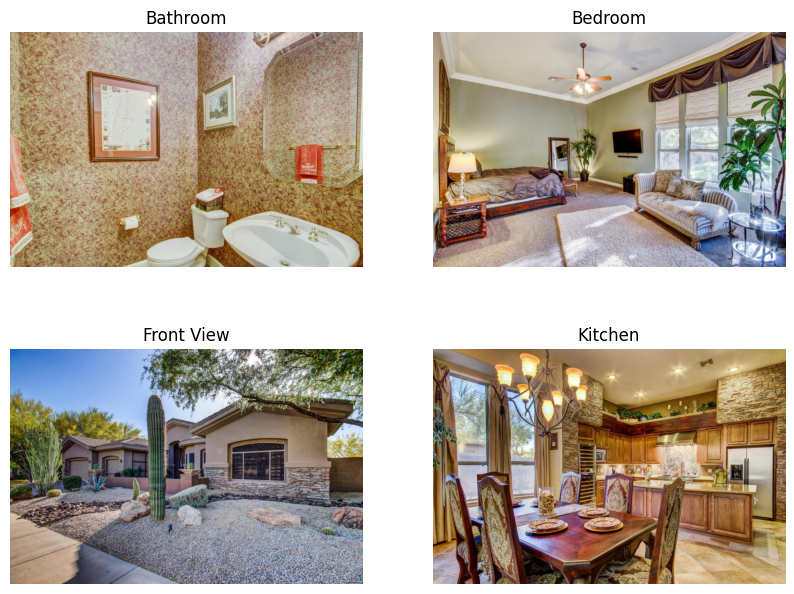

In [9]:

images = sorted(list(glob.glob(os.path.sep.join([CFG.images_path, "{}_*".format(1)]))))

titles = ["Bathroom", "Bedroom", "Front View", "Kitchen"]

fig, axes = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': -0.3})

for i, ax in enumerate(axes.flatten()):
    if i < len(images):
        image = cv2.imread(images[i])[..., ::-1]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(titles[i])
plt.show()

In [ ]:
def image_read(size=256):
    images = []
    for i in df.index.values:
        basepath = os.path.sep.join([CFG.images_path, "{}_*".format(i + 1)]).replace('\\', '/')
        imagepaths = sorted(glob.glob(basepath)) 
        
 
        inputImages = [
            cv2.resize(cv2.imread(imagepath), (size // 2, size // 2)) for imagepath in imagepaths
        ]
        
        outputImage = np.concatenate([
            np.concatenate(inputImages[:2], axis=1),  
            np.concatenate(inputImages[2:], axis=1)
        ], axis=0)  
        images.append(outputImage)

    return np.array(images)

In [11]:
images = image_read()

In [12]:
images.shape

(535, 256, 256, 3)

* We can display each house in this format.

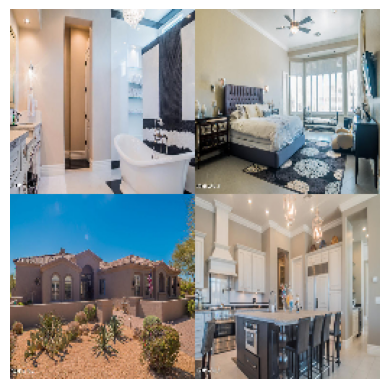

In [13]:
plt.imshow(images[5][..., ::-1])
plt.axis('off')
plt.show()

## Feature Engineering

In [14]:
df

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [15]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms'] + 1 # plus kitchen

df['bedrooms_per_bathroom'] = df['bedrooms'] / df['bathrooms']

df['area_per_bedroom'] = df['area'] / df['bedrooms']

df['area_per_bathroom'] = df['area'] / df['bathrooms']

df['avg_room_area'] = df['area'] / df['total_rooms']

df['bedrooms_area_interaction'] = df['bedrooms'] * df['area']

df['bathrooms_area_interaction'] = df['bathrooms'] * df['area']

df['zipcode_avg_price'] = df.groupby('zipcode')['price'].transform('mean')

df['zipcode_median_price'] = df.groupby('zipcode')['price'].transform('median')

df['zipcode_price_diff'] = df['price'] - df['zipcode_avg_price']

df['price_per_bedroom'] = df['price'] / df['bedrooms']

df['price_per_bathroom'] = df['price'] / df['bathrooms']

df['price_per_area'] = df['price'] / df['area']



In [ ]:
def SIFT(image, plot=True):
    """
    Extracting SIFT features from an image.

    Parameters:
        image: Input image (should be in BGR format).
        plot: If True, draws the keypoints on the image.
        
    Returns:
        keypoints: The keypoints.
        descriptors: The features of the keypoints.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sift = cv2.SIFT_create()
    
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if plot:
        image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title('Image with Keypoints')
        plt.axis('off')
        plt.show()
    else:
        mean_array = np.mean(descriptors, axis=0)
        mean_array = mean_array.ravel()
        return mean_array

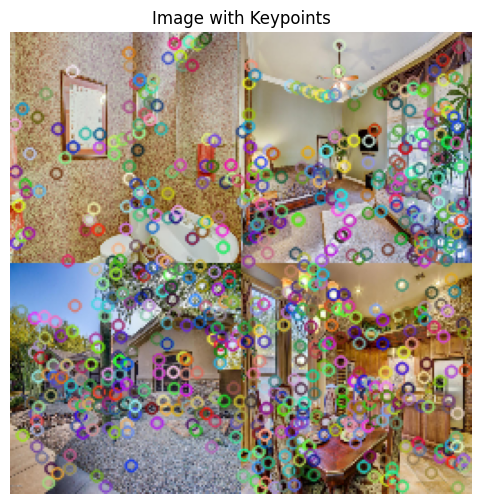

In [17]:
SIFT(images[0])

In [18]:
siftedimages = []
for img in images:
    siftedimage = SIFT(img, plot=False)
    siftedimages.append(siftedimage)

In [19]:
len(siftedimages)

535

In [20]:
siftedimages[0].shape

(128,)

In [21]:
sift_images = np.vstack(siftedimages)

In [22]:
sift_images.shape

(535, 128)

In [23]:
sift_images

array([[24.480305, 21.003813, 23.945362, ..., 15.987293, 14.213469,
        14.104193],
       [23.08589 , 20.251534, 21.817995, ..., 16.501022, 12.02454 ,
        12.997955],
       [21.504974, 20.72388 , 20.450249, ..., 13.176617, 11.067164,
        11.587065],
       ...,
       [23.316854, 21.593258, 25.258427, ..., 13.730337, 15.932584,
        16.408989],
       [23.795725, 19.351543, 22.581947, ..., 14.396674, 15.368171,
        13.950119],
       [22.174633, 19.737133, 23.693014, ..., 12.036765, 12.273897,
        14.136029]], dtype=float32)

## EDA


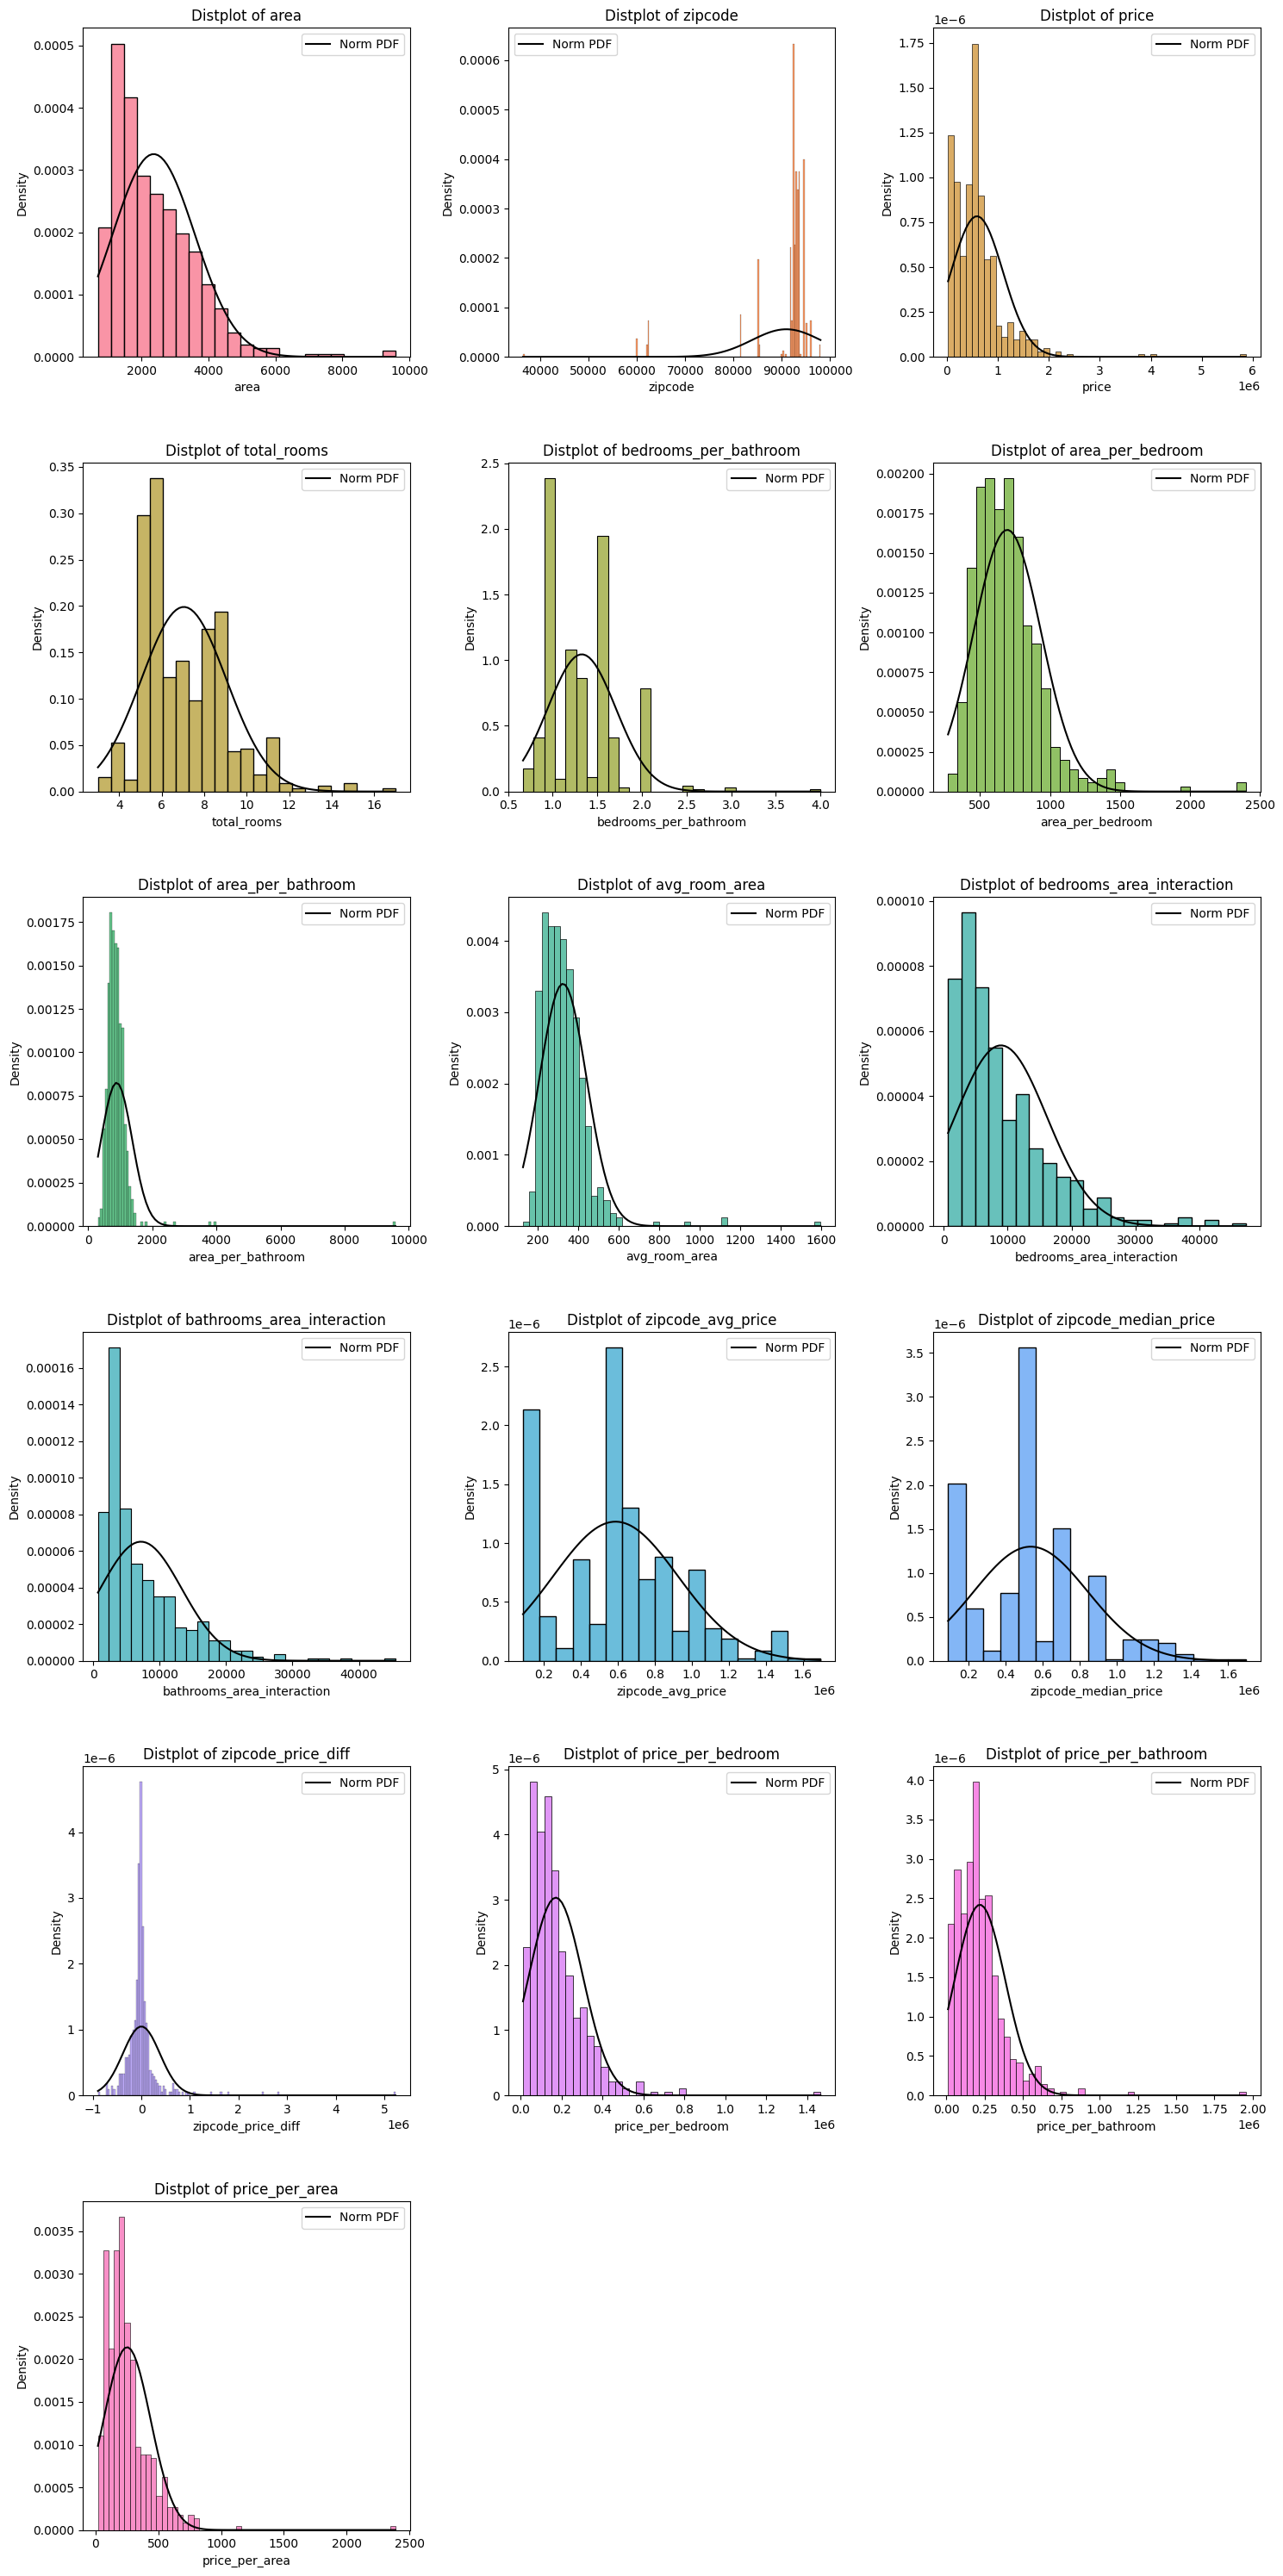

In [ ]:
def plot_distplots(df):
    """
    Plots distplots for each column in the given dataframe.

    Arguments:
    df (pandas.DataFrame): The dataframe for which distplots will be created.
    """

    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_but_categorical = [col for col in numeric_cols if df[col].nunique() < 15]
    numeric_cols=[col for col in numeric_cols if col not in numeric_but_categorical]
    
    num_cols = 3  
    num_rows = int(np.ceil(len(numeric_cols) / num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    colors = sns.color_palette('husl', len(numeric_cols))
    
    for i, col in enumerate(numeric_cols):
        row = i // num_cols
        col_pos = i % num_cols
        ax = axes[row, col_pos]
        
        sns.histplot(df[col], kde=False, color=colors[i], ax=ax, stat='density')
        
        mean = df[col].mean()
        std = df[col].std()
        x = np.linspace(df[col].min(), df[col].max(), 100)
        norm_pdf = stats.norm.pdf(x, mean, std)
        
        ax.plot(x, norm_pdf, color='black', label='Norm PDF')
        
        ax.set_title(f'Distplot of {col}')
        ax.legend()
    
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(h_pad=3)  # h_pad parametresi ile dikey boşluğu arttırın
    plt.show()

plot_distplots(df)

In [ ]:
def analyze_target_feature(df, target):
    """
    Analyzes each categorical and numerical variable in relation to the target variable.

    Arguments:
    df (pandas.DataFrame): The dataframe to analyze.
    target (str): The name of the target variable.
    """
    # Kategorik değişkenlerin hedef değişkene göre ortalamasını hesapla
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        print(f"\nKategorik değişken: {col}")
        try:
            # Sadece sayısal değerlere sahip satırları seç
            group_means = df.groupby(col)[target].mean()
            print(group_means)
        except TypeError:
            print(f"{col} sütununda bazı değerler sayısal değil, ortalama hesaplanamadı.")
    
    # Hedef değişkene göre sayısal değişkenlerin ortalamasını hesapla
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        print(f"\nSayısal değişken: {col}")
        print(df.groupby(target)[col].mean())

In [26]:
analyze_target_feature(df,CFG.target)


Sayısal değişken: bedrooms
price
22000      2.0
36000      2.0
42900      2.0
49900      2.0
50000      2.0
          ... 
2200000    6.0
2395000    3.0
3850000    6.0
4000000    5.0
5858000    4.0
Name: bedrooms, Length: 369, dtype: float64

Sayısal değişken: bathrooms
price
22000      2.0
36000      1.0
42900      2.0
49900      1.0
50000      2.0
          ... 
2200000    5.5
2395000    2.0
3850000    6.5
4000000    4.5
5858000    3.0
Name: bathrooms, Length: 369, dtype: float64

Sayısal değişken: area
price
22000      1056.0
36000      1100.0
42900      1020.0
49900       960.0
50000      1248.0
            ...  
2200000    5000.0
2395000    2971.0
3850000    7000.0
4000000    5000.0
5858000    2454.0
Name: area, Length: 369, dtype: float64

Sayısal değişken: zipcode
price
22000      96019.0
36000      92276.0
42900      92276.0
49900      92276.0
50000      92276.0
            ...   
2200000    93446.0
2395000    93446.0
3850000    92677.0
4000000    93111.0
5858000    93510.0
Na

In [27]:
df.describe().T.drop(['count', 'std'], axis=1)

,mean,min,25%,50%,75%,max
bedrooms,3.377570e+00,1.000000,3.000000,3.000000,4.000000,1.000000e+01
bathrooms,2.664953e+00,1.000000,2.000000,2.500000,3.000000,7.000000e+00
area,2.364905e+03,701.000000,1440.000000,2078.000000,3067.500000,9.583000e+03
zipcode,9.093777e+04,36372.000000,92276.000000,92880.000000,93510.000000,9.802100e+04
price,5.893628e+05,22000.000000,249200.000000,529000.000000,728500.000000,5.858000e+06
total_rooms,7.042523e+00,3.000000,5.500000,6.500000,8.000000,1.700000e+01
bedrooms_per_bathroom,1.325184e+00,0.666667,1.000000,1.333333,1.500000,4.000000e+00
area_per_bedroom,6.940385e+02,271.000000,528.000000,654.250000,800.000000,2.395750e+03
area_per_bathroom,8.918348e+02,309.714286,703.125000,844.333333,1003.916667,9.583000e+03
avg_room_area,3.249440e+02,127.529412,249.600000,307.600000,373.992105,1.597167e+03


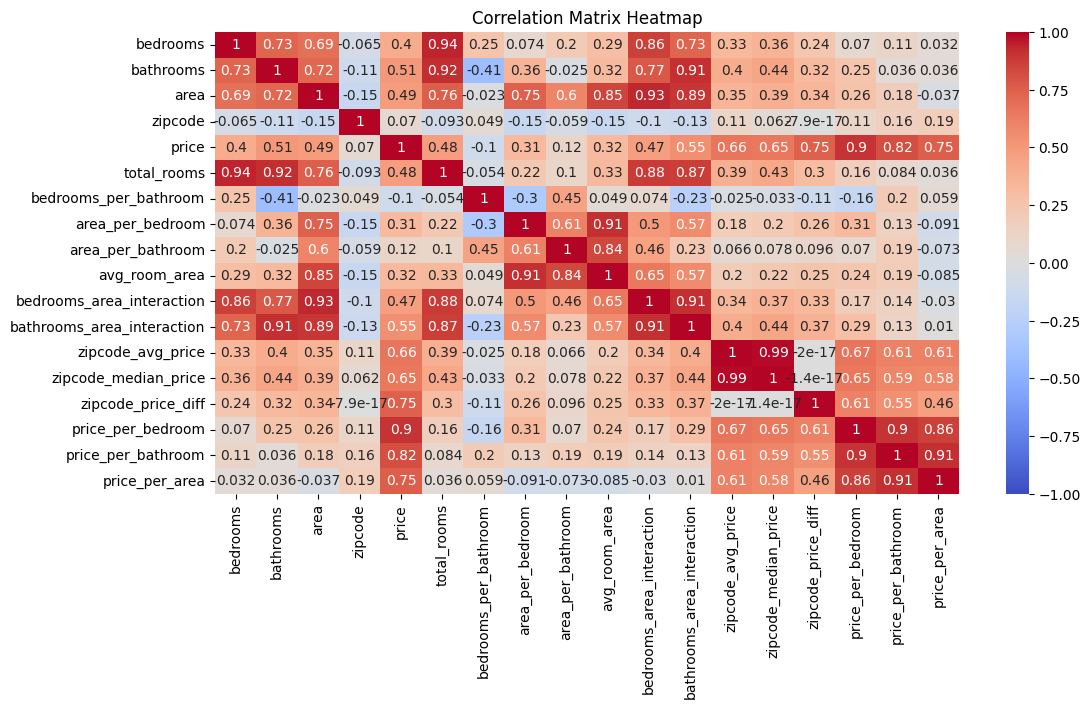

In [28]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [29]:
correlation_matrix['price'].sort_values(ascending=False)[1:]

price_per_bedroom             0.901675
price_per_bathroom            0.819842
price_per_area                0.751789
zipcode_price_diff            0.748357
zipcode_avg_price             0.663296
zipcode_median_price          0.653391
bathrooms_area_interaction    0.547089
bathrooms                     0.505018
area                          0.491725
total_rooms                   0.481455
bedrooms_area_interaction     0.469089
bedrooms                      0.398655
avg_room_area                 0.316081
area_per_bedroom              0.313393
area_per_bathroom             0.115433
zipcode                       0.070073
bedrooms_per_bathroom        -0.100748
Name: price, dtype: float64

## Data Preproessing

In [30]:
X = df.drop(CFG.target, axis=1)
y = df[CFG.target]

In [31]:
print(X.shape)
print(y.shape)

(535, 17)
(535,)


In [32]:
sift_images.shape

(535, 128)

In [33]:
X = np.hstack([sift_images, X])
X.shape

(535, 145)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model: RF
Cross-validation Mean MAPE: 0.1007 (Std: 0.0190)
Model: GBM
Cross-validation Mean MAPE: 0.0986 (Std: 0.0184)
Model: XGBM
Cross-validation Mean MAPE: 0.0951 (Std: 0.0118)
Model: LightGBM
Cross-validation Mean MAPE: 0.1426 (Std: 0.0492)
Model: KNN
Cross-validation Mean MAPE: 0.0908 (Std: 0.0590)
Model: Decision Tree
Cross-validation Mean MAPE: 0.1544 (Std: 0.0197)
Model: AdaBoost
Cross-validation Mean MAPE: 0.4901 (Std: 0.0912)

Cross-validation Mean MAPE and Std MAPE Comparison:
           Model  Cross-validation Mean MAPE  Cross-validation Std MAPE
4            KNN                    0.090818                   0.059016
2           XGBM                    0.095095                   0.011768
1            GBM                    0.098561                   0.018401
0             RF                    0.100687                   0.019044
3       LightGBM                    0.142568                   0.049182
5  Decision Tree                    0.154417                   0.019659
6  

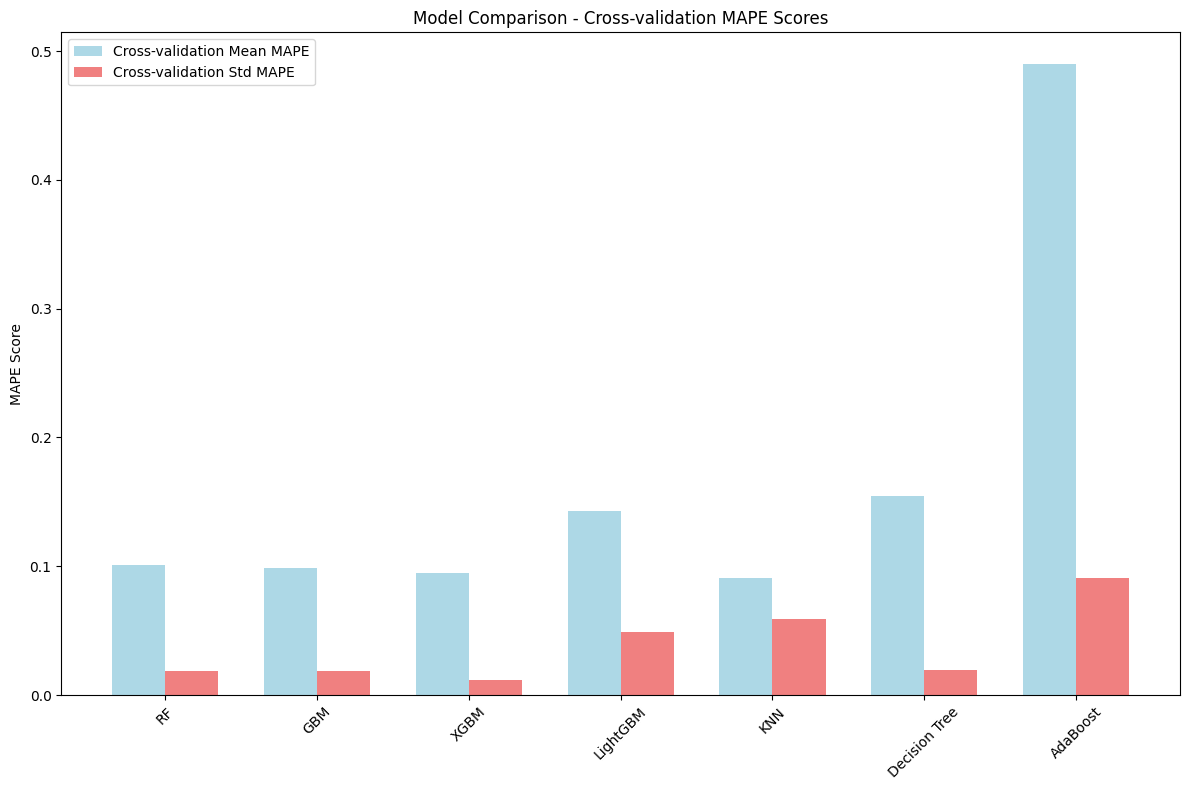

In [35]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom scorer for MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Models to evaluate
models = [
    ('RF', RandomForestRegressor()),
    ('GBM', GradientBoostingRegressor()),
    ('XGBM', XGBRegressor()),
    ("LightGBM", LGBMRegressor(verbose=-1)),
    ('KNN', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('AdaBoost', AdaBoostRegressor())
]

results = []
names = []
cv_mean_mape_scores = []
cv_std_mape_scores = []

for name, model in models:
    model.fit(X_train, y_train)

    # Cross-validation with MAPE
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=mape_scorer)
    
    cv_mean_mape = -cv_results.mean()  # Negate because MAPE is inverted by make_scorer
    cv_std_mape = cv_results.std()
    cv_mean_mape_scores.append(cv_mean_mape)
    cv_std_mape_scores.append(cv_std_mape)
    names.append(name)
    
    print(f"Model: {name}")
    print(f"Cross-validation Mean MAPE: {cv_mean_mape:.4f} (Std: {cv_std_mape:.4f})")

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Model": names,
    "Cross-validation Mean MAPE": cv_mean_mape_scores,
    "Cross-validation Std MAPE": cv_std_mape_scores
}).sort_values(by="Cross-validation Mean MAPE")

print("\nCross-validation Mean MAPE and Std MAPE Comparison:")
print(comparison_df[["Model", "Cross-validation Mean MAPE", "Cross-validation Std MAPE"]])

# Visualization of MAPE scores
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
x = np.arange(len(names))

ax.bar(x - bar_width/2, cv_mean_mape_scores, bar_width, label='Cross-validation Mean MAPE', color='lightblue')
ax.bar(x + bar_width/2, cv_std_mape_scores, bar_width, label='Cross-validation Std MAPE', color='lightcoral')

ax.set_title('Model Comparison - Cross-validation MAPE Scores')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45)
ax.set_ylabel('MAPE Score')
ax.legend()
plt.tight_layout()
plt.show()


* By examining the difference between train and test scores, we can assess whether models are relatively overfitting. These values indicate that the model is not overfitting.

## Data Prepossing for Neural Network

In [36]:
df_cnn = df.copy

In [37]:
df_cnn = df[['bedrooms', 'bathrooms', 'area', 'price']]

In [38]:
nn_images = image_read(size=64)

In [39]:
len(nn_images)

535

In [40]:
X_train, X_test, X_train_img, X_test_img = train_test_split(df_cnn, nn_images, random_state=42)

max_price = df_cnn['price'].max()
y_train = (X_train['price'] / max_price).values
y_test = (X_test['price'] / max_price).values


In [41]:
X_train_img = X_train_img / 255.0
X_test_img = X_test_img / 255.0

In [42]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train[['bedrooms', 'bathrooms', 'area']])
X_test = scaler.transform(X_test[['bedrooms', 'bathrooms', 'area']])

In [43]:
def create_cnn(input_shape):
    """
    Creates a CNN model.
    
    Args:
        input_shape (tuple): Shape of the CNN input (e.g., (64, 64, 3)).
    
    Returns:
        Model: A Keras model for processing image data.
    """
    input_img = Input(shape=input_shape, name="CNN_Input")
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)

    return Model(inputs=input_img, outputs=x, name="CNN_Model")

def create_mlp(input_shape):
    """
    Creates an MLP model.
    
    Args:
        input_shape (tuple): Shape of the MLP input (e.g., (3,)).
    
    Returns:
        Model: A Keras model for processing tabular data.
    """
    input_data = Input(shape=input_shape, name="MLP_Input")
    x = Dense(16, activation='relu')(input_data)
    x = Dropout(0.5)(x)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)

    return Model(inputs=input_data, outputs=x, name="MLP_Model")

def create_combined_model(cnn_model, mlp_model):
    """
    Combines the outputs of CNN and MLP models and adds fully connected layers.
    
    Args:
        cnn_model (Model): A Keras model for image data.
        mlp_model (Model): A Keras model for tabular data.
    
    Returns:
        Model: The combined Keras model.
    """
    combined = concatenate([cnn_model.output, mlp_model.output], name="Concatenated")
    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.3)(x)  # Adding dropout to prevent overfitting
    x = Dense(16, activation='relu')(x)
    output = Dense(1, activation='linear', name="Output")(x)

    return Model(inputs=[cnn_model.input, mlp_model.input], outputs=output, name="Combined_Model")




In [44]:
def build_and_compile_model(cnn_input_shape, mlp_input_shape):
    """
    Builds, compiles, and returns the combined model.
    
    Args:
        cnn_input_shape (tuple): Shape of the CNN input.
        mlp_input_shape (tuple): Shape of the MLP input.
    
    Returns:
        Model: The compiled Keras model.
    """
    cnn_model = create_cnn(cnn_input_shape)
    mlp_model = create_mlp(mlp_input_shape)
    combined_model = create_combined_model(cnn_model, mlp_model)

    combined_model.compile(optimizer='adam', loss='mape', metrics=['mape'])
    return combined_model


cnn_input_shape = (64, 64, 3)
mlp_input_shape = (3,)
model = build_and_compile_model(cnn_input_shape, mlp_input_shape)

# Display the model summary
model.summary()

Model: "Combined_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ CNN_Input           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        448 │ CNN_Input[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MLP_Input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    131,104 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │         64 │ MLP_Input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        136 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout[0][0]   

 Total params: 157,245 (614.24 KB)

 Trainable params: 156,957 (613.11 KB)

 Non-trainable params: 288 (1.12 KB)

In [45]:
model.compile(loss='mean_absolute_percentage_error', optimizer=Adam(0.01))

In [46]:
history = model.fit(
    [X_train_img, X_train],
    y_train,
    validation_data=([X_test_img, X_test], y_test),
    epochs=220,
    batch_size=10,
)

Epoch 1/220


c:\Users\utku-\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['CNN_Input', 'MLP_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 648.6655 - mape: 648.6655 - val_loss: 2525.0066 - val_mape: 2525.0066
Epoch 2/220
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 157.7061 - mape: 157.7061 - val_loss: 77.5305 - val_mape: 77.5305
Epoch 3/220
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 87.1299 - mape: 87.1299 - val_loss: 89.2266 - val_mape: 89.2266
Epoch 4/220
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 76.9443 - mape: 76.9443 - val_loss: 74.2936 - val_mape: 74.2936
Epoch 5/220
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 62.4611 - mape: 62.4611 - val_loss: 68.6859 - val_mape: 68.6859
Epoch 6/220
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 71.3109 - mape: 71.3109 - val_loss: 154.7960 - val_mape: 154.7960
Epoch 7/220
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 62.2991 - mape: 62.2991 - val_loss: 80.7322 - val_mape: 80.7322
Epoch 8/220
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 67.4204 - mape: 67.4204 - val_loss: 71.6352 - val_mape: 71.6352
Epoch 9/220
41/41

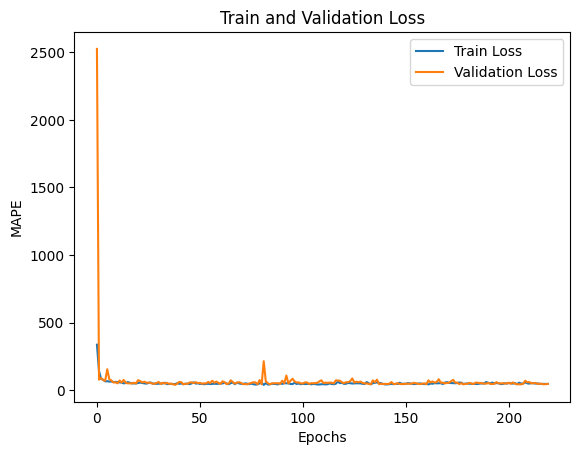

In [50]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [48]:
predicts =  model.predict([X_test_img,X_test])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [49]:
mean_absolute_percentage_error(y_pred=predicts.flatten(), y_true=(y_test))

0.45720477977089685

## Conclusion

* In this study, different approaches were explored to model a complex dataset consisting of both image and tabular data. Specifically, the performance of a combined deep learning model (Combine Model) and various machine learning models was compared. The results are summarized as follows:

#### Combined Deep Learning Model 


* Mean Absolute Percentage Error (MAPE): 0.4572
The model, created by combining CNN and MLP, has the capacity to process both image and tabular data simultaneously. However, the relatively high MAPE value indicates that the model struggled to capture all variations within the complex dataset.


#### Machine Learning Models


* KNN: With a Mean MAPE value of 0.0908, KNN achieved the lowest error, demonstrating its ability to effectively capture local structures and relationships in the dataset. However, the higher standard deviation (0.0590) compared to other models suggests potential inconsistencies in certain areas.

* XGBM: Ranking second with a Mean MAPE of 0.0951, XGBM also exhibited a low standard deviation (0.0118), indicating a more consistent modeling performance. This highlights XGBM’s strong generalization capability.


## General Evaluation


- Machine learning models, particularly KNN and XGBM, achieved significantly low Mean MAPE values, delivering successful results. This suggests that these models are well-suited to the problem structure and the characteristics of the dataset. On the other hand, the relatively underwhelming performance of the more complex "combined" model highlights the need for further model optimization and additional data preprocessing efforts.